In [1]:
import os
import math
import shutil
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm, trange

import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmaps
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import NullFormatter, FixedLocator, FormatStrFormatter, MultipleLocator, PercentFormatter, FuncFormatter
import matplotlib.ticker as mticker

import xarray as xr

In [ ]:
fontsize = 10

version = "daily_100"
BENCHMARK_DIR = Path("/data6t/AIWP_TP_dataset/benchmark")

QC_data_path = Path("/data6t/AIWP_TP_dataset/QC_data")
QC_daily_data_path = QC_data_path / "daily"

ERA5_daily_tp_path = BENCHMARK_DIR / "ERA5_tp_24h_rolling.zarr"

In [4]:
station_info_df = pd.read_csv(QC_data_path / f"{version}_station_info_2025.csv")
station_info_df

,ID,LATITUDE,LONGITUDE,ELEVATION,FREQUENCY,best_shift_hour,reporting_time,year_length
0,GHCNh_ACW00011647,17.13330,298.21670,19.2,6,4.0,-4.0,4.750685
1,GHCNh_AGI0000DAAT,22.81150,5.45110,1377.1,3,48.0,-48.0,0.865753
2,GHCNh_AGI0000DAOH,34.82000,358.23000,426.0,24,5.0,-5.0,5.232877
3,GHCNh_AGM00060353,36.81670,5.88330,6.0,6,2.0,-2.0,0.802740
4,GHCNh_AGM00060395,36.70000,4.13330,153.0,24,7.0,-7.0,5.254795
...,...,...,...,...,...,...,...,...
58791,GSOD_A0000253928,30.21889,263.62583,93.9,24,-17.0,17.0,3.290411
58792,GSOD_A0000594076,40.05361,253.63111,2258.9,24,-15.0,15.0,3.306849
58793,GSOD_A0002453848,30.51195,273.04594,34.0,24,-17.0,17.0,4.465753
58794,GSOD_A0003225715,52.22028,185.79389,17.1,24,-14.0,14.0,2.232877


In [5]:
QC_daily_tp = xr.open_dataset(QC_data_path / f"PRCP_QC_flags_{version}_2020_2025.nc").load()
QC_daily_tp

<xarray.Dataset> Size: 3GB
Dimensions:                          (station: 58796, time: 2192)
Coordinates:
  * station                          (station) <U17 4MB 'GHCNd_US1NMSC0063' ....
  * time                             (time) datetime64[ns] 18kB 2020-01-01 .....
    latitude                         (station) float64 470kB 34.08 ... 39.96
    longitude                        (station) float64 470kB 252.8 ... 41.17
    elevation                        (station) float64 470kB 2.188e+03 ... 1....
Data variables: (12/15)
    raw_data                         (station, time) float32 516MB 0.0 ... nan
    qc_data                          (station, time) float32 516MB 0.0 ... nan
    flags_num                        (station, time) float32 516MB 12.0 ... nan
    duplicate_flags                  (station, time) int8 129MB 1 1 1 ... -1 -1
    exceedance_flags                 (station, time) int8 129MB 1 1 1 ... -1 -1
    identical_streak_flags           (station, time) int8 129MB 1 1 1 ... -1 -1
    ...                               ...
    spatial_flags                    (station, time) int8 129MB 1 1 1 ... -1 -1
    nonzero_repetition_flags         (station, time) int8 129MB 1 1 1 ... -1 -1
    duplicate_submonth_flags         (station, time) int8 129MB 1 1 1 ... -1 -1
    zscore_outlier_flags             (station, time) int8 129MB 1 1 1 ... -1 -1
    spatiotemporally_isolated_flags  (station, time) int8 129MB 1 1 1 ... -1 -1
    erroneous_zero_flags             (station, time) int8 129MB 1 1 1 ... -1 -1

In [7]:
QC_daily_tp = QC_daily_tp.assign_coords(
    era5_best_shift_hour=(("station"), 
                     station_info_df.set_index("ID").loc[
                         [id for id in QC_daily_tp["station"].data], "reporting_time"].values))
QC_daily_tp

<xarray.Dataset> Size: 3GB
Dimensions:                          (station: 58796, time: 2192)
Coordinates:
  * station                          (station) <U17 4MB 'GHCNd_US1NMSC0063' ....
  * time                             (time) datetime64[ns] 18kB 2020-01-01 .....
    latitude                         (station) float64 470kB 34.08 ... 39.96
    longitude                        (station) float64 470kB 252.8 ... 41.17
    elevation                        (station) float64 470kB 2.188e+03 ... 1....
    era5_best_shift_hour             (station) float64 470kB 8.0 11.0 ... -7.0
Data variables: (12/15)
    raw_data                         (station, time) float32 516MB 0.0 ... nan
    qc_data                          (station, time) float32 516MB 0.0 ... nan
    flags_num                        (station, time) float32 516MB 12.0 ... nan
    duplicate_flags                  (station, time) int8 129MB 1 1 1 ... -1 -1
    exceedance_flags                 (station, time) int8 129MB 1 1 1 ... -1 -1
    identical_streak_flags           (station, time) int8 129MB 1 1 1 ... -1 -1
    ...                               ...
    spatial_flags                    (station, time) int8 129MB 1 1 1 ... -1 -1
    nonzero_repetition_flags         (station, time) int8 129MB 1 1 1 ... -1 -1
    duplicate_submonth_flags         (station, time) int8 129MB 1 1 1 ... -1 -1
    zscore_outlier_flags             (station, time) int8 129MB 1 1 1 ... -1 -1
    spatiotemporally_isolated_flags  (station, time) int8 129MB 1 1 1 ... -1 -1
    erroneous_zero_flags             (station, time) int8 129MB 1 1 1 ... -1 -1

# Fig.3

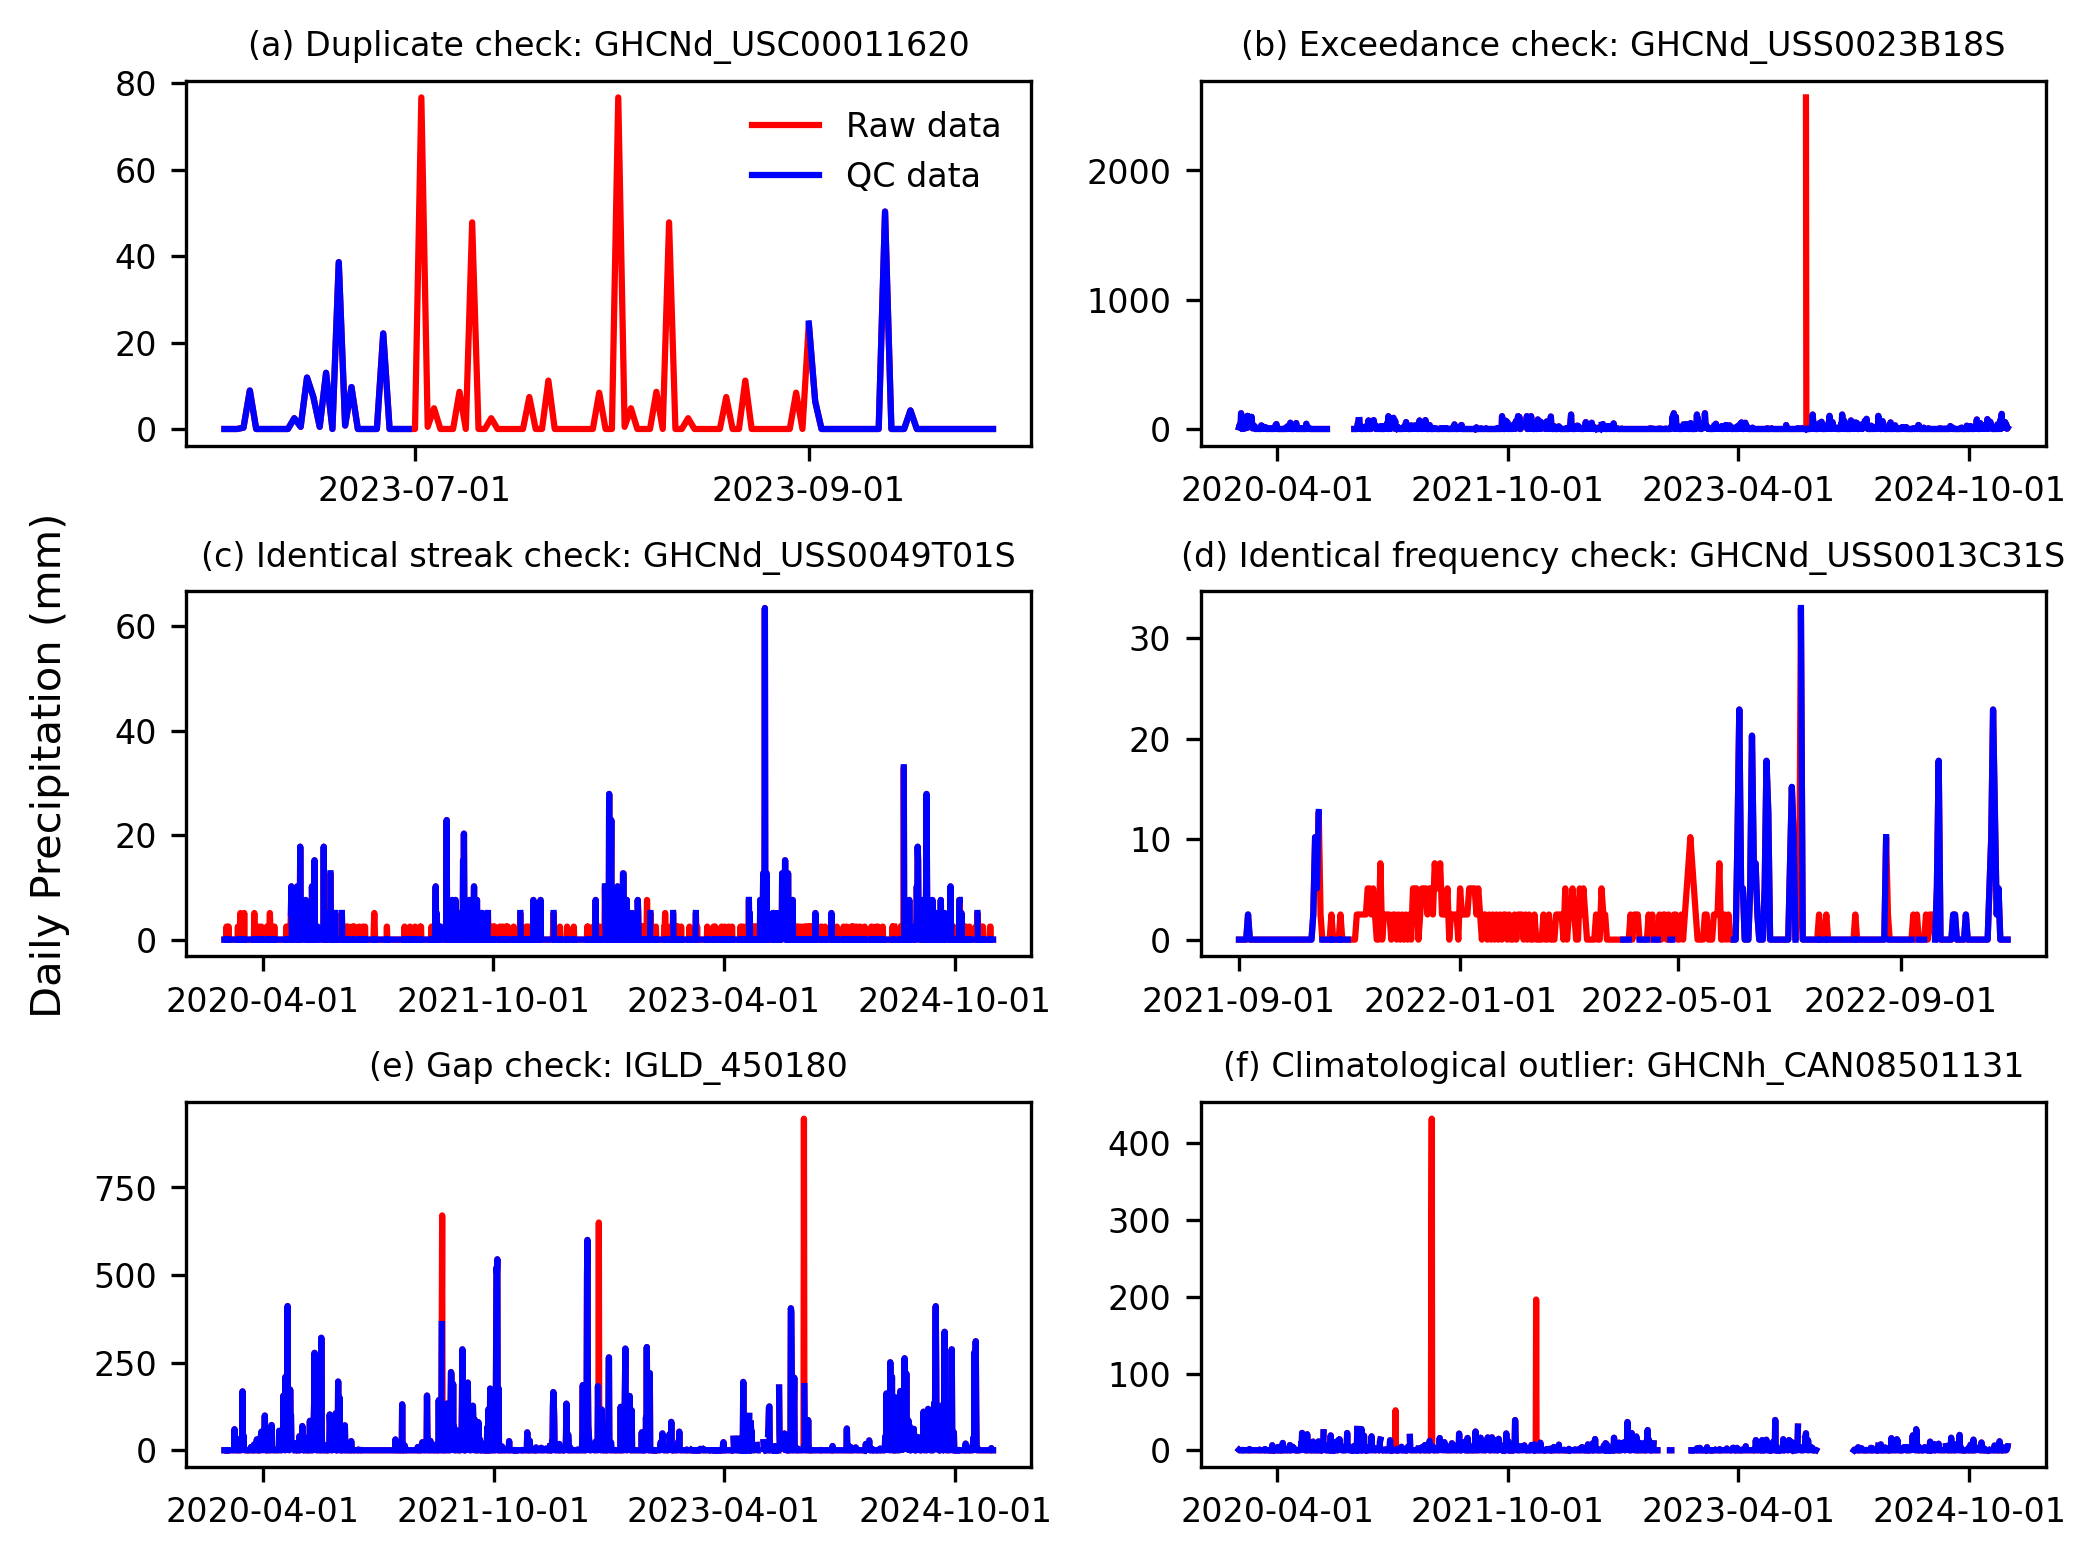

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), dpi=300)
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

colors = {"Raw": "red", "QC": "blue"}
fig.supylabel("Daily Precipitation (mm)", fontsize=fontsize, x=0.06)

for i, (sid, months, date_range, flag_name) in enumerate([
        (47162, 2, pd.date_range(start="2023-06-01", end="2023-9-30"), "Duplicate check"),
        (41556, 18, QC_daily_tp["time"].data, "Exceedance check"),
        (26256, 18, QC_daily_tp["time"].data, "Identical streak check"),
        (11153, 4, pd.date_range(start="2021-09-01", end="2022-10-30"), "Identical frequency check"),
        (17202, 18, QC_daily_tp["time"].data, "Gap check"),
        (58545, 18, QC_daily_tp["time"].data, "Climatological outlier")
    ]):
    ax = axes[i]
    sample = QC_daily_tp[["raw_data", "qc_data"]].isel(station=sid)
    station_id = sample["station"].data.item()
    ax.set_title(f"({chr(97+i)}) {flag_name}: {station_id}", fontsize=fontsize-2)
    # ax.scatter(sample["time"].sel(time=date_range), sample["raw_data"].sel(time=date_range), label="Raw data", color=colors["Raw"], s=1)
    # ax.scatter(sample["time"].sel(time=date_range), sample["qc_data"].sel(time=date_range), label="QC data", color=colors["QC"], s=1)
    ax.plot(sample["time"].sel(time=date_range), sample["raw_data"].sel(time=date_range), label="Raw data", color=colors["Raw"])
    ax.plot(sample["time"].sel(time=date_range), sample["qc_data"].sel(time=date_range), label="QC data", color=colors["QC"])
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=months))
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
axes[0].legend(fontsize=fontsize-2, loc="upper right", frameon=False)

fig.savefig("figures/Figure 2.jpg", dpi=300, bbox_inches="tight")

# Fig.4

In [27]:
QC_daily_tp["Duplicate and exceedance check"] = QC_daily_tp["duplicate_flags"] + QC_daily_tp["exceedance_flags"]
QC_daily_tp["Duplicate and exceedance check"] = QC_daily_tp["Duplicate and exceedance check"].where(QC_daily_tp["Duplicate and exceedance check"]>=0, -1)
QC_daily_tp["Duplicate and exceedance check"] = QC_daily_tp["Duplicate and exceedance check"].where(QC_daily_tp["Duplicate and exceedance check"]!=1, 0)
QC_daily_tp["Duplicate and exceedance check"] = QC_daily_tp["Duplicate and exceedance check"].where(QC_daily_tp["Duplicate and exceedance check"]!=2, 1)

QC_daily_tp["Identical value check"] = QC_daily_tp["identical_streak_flags"] + QC_daily_tp["identical_frequent_flags"]
QC_daily_tp["Identical value check"] = QC_daily_tp["Identical value check"].where(QC_daily_tp["Identical value check"]>=0, -1)
QC_daily_tp["Identical value check"] = QC_daily_tp["Identical value check"].where(QC_daily_tp["Identical value check"]!=1, 0)
QC_daily_tp["Identical value check"] = QC_daily_tp["Identical value check"].where(QC_daily_tp["Identical value check"]!=2, 1)

QC_daily_tp["Outlier check"] = QC_daily_tp["gap_flags"] + QC_daily_tp["climatological_flags"]
QC_daily_tp["Outlier check"] = QC_daily_tp["Outlier check"].where(QC_daily_tp["Outlier check"]>=0, -1)
QC_daily_tp["Outlier check"] = QC_daily_tp["Outlier check"].where(QC_daily_tp["Outlier check"]!=1, 0)
QC_daily_tp["Outlier check"] = QC_daily_tp["Outlier check"].where(QC_daily_tp["Outlier check"]!=2, 1)

QC_daily_tp["Spatial consistency check"] = QC_daily_tp["spatial_flags"] 

QC_daily_tp["Basic integrity checks"] = QC_daily_tp["Duplicate and exceedance check"] + QC_daily_tp["Identical value check"] + QC_daily_tp["Outlier check"] + QC_daily_tp["Spatial consistency check"]
QC_daily_tp["Basic integrity checks"] = QC_daily_tp["Basic integrity checks"].where(QC_daily_tp["Basic integrity checks"]>=0, -1)
QC_daily_tp["Basic integrity checks"] = QC_daily_tp["Basic integrity checks"].where(QC_daily_tp["Basic integrity checks"]!=1, 0)
QC_daily_tp["Basic integrity checks"] = QC_daily_tp["Basic integrity checks"].where(QC_daily_tp["Basic integrity checks"]!=2, 0)
QC_daily_tp["Basic integrity checks"] = QC_daily_tp["Basic integrity checks"].where(QC_daily_tp["Basic integrity checks"]!=3, 0)
QC_daily_tp["Basic integrity checks"] = QC_daily_tp["Basic integrity checks"].where(QC_daily_tp["Basic integrity checks"]!=4, 1)

QC_daily_tp

<xarray.Dataset> Size: 4GB
Dimensions:                            (station: 58796, time: 2192)
Coordinates:
  * station                            (station) <U17 4MB 'GHCNd_US1NMSC0063'...
  * time                               (time) datetime64[ns] 18kB 2020-01-01 ...
    latitude                           (station) float64 470kB 34.08 ... 39.96
    longitude                          (station) float64 470kB 252.8 ... 41.17
    elevation                          (station) float64 470kB 2.188e+03 ... ...
    era5_best_shift_hour               (station) float64 470kB 8.0 11.0 ... -7.0
Data variables: (12/21)
    raw_data                           (station, time) float32 516MB 0.0 ... nan
    qc_data                            (station, time) float32 516MB 0.0 ... nan
    flags_num                          (station, time) float32 516MB 12.0 ......
    duplicate_flags                    (station, time) int8 129MB 1 1 ... -1 -1
    exceedance_flags                   (station, time) int8 129MB 1 1 ... -1 -1
    identical_streak_flags             (station, time) int8 129MB 1 1 ... -1 -1
    ...                                 ...
    Duplicate and exceedance check     (station, time) int8 129MB 1 1 ... -1 -1
    Identical value check              (station, time) int8 129MB 1 1 ... -1 -1
    Outlier check                      (station, time) int8 129MB 1 1 ... -1 -1
    Spatial consistency check          (station, time) int8 129MB 1 1 ... -1 -1
    Basic integrity checks             (station, time) int8 129MB 1 1 ... -1 -1
    Spatiotemporal consistency checks  (station, time) int8 129MB 1 1 ... -1 -1

In [29]:
QC_daily_tp_nonan = (QC_daily_tp[["Basic integrity checks", "Duplicate and exceedance check", "Identical value check", "Outlier check", "Spatial consistency check"]] != -1).sum(dim="station")
QC_daily_tp_nonan_fail = (QC_daily_tp[["Basic integrity checks", "Duplicate and exceedance check", "Identical value check", "Outlier check", "Spatial consistency check"]] == 0).sum(dim="station")

QC_daily_tp_nonan_fail_rate = QC_daily_tp_nonan_fail / QC_daily_tp_nonan
QC_daily_tp_nonan_fail_rate

<xarray.Dataset> Size: 105kB
Dimensions:                         (time: 2192)
Coordinates:
  * time                            (time) datetime64[ns] 18kB 2020-01-01 ......
Data variables:
    Basic integrity checks          (time) float64 18kB 0.001528 ... 0.001114
    Duplicate and exceedance check  (time) float64 18kB 5.766e-05 ... 0.0
    Identical value check           (time) float64 18kB 0.00147 ... 0.001114
    Outlier check                   (time) float64 18kB 0.0 0.0 0.0 ... 0.0 0.0
    Spatial consistency check       (time) float64 18kB 0.0 0.0 0.0 ... 0.0 0.0

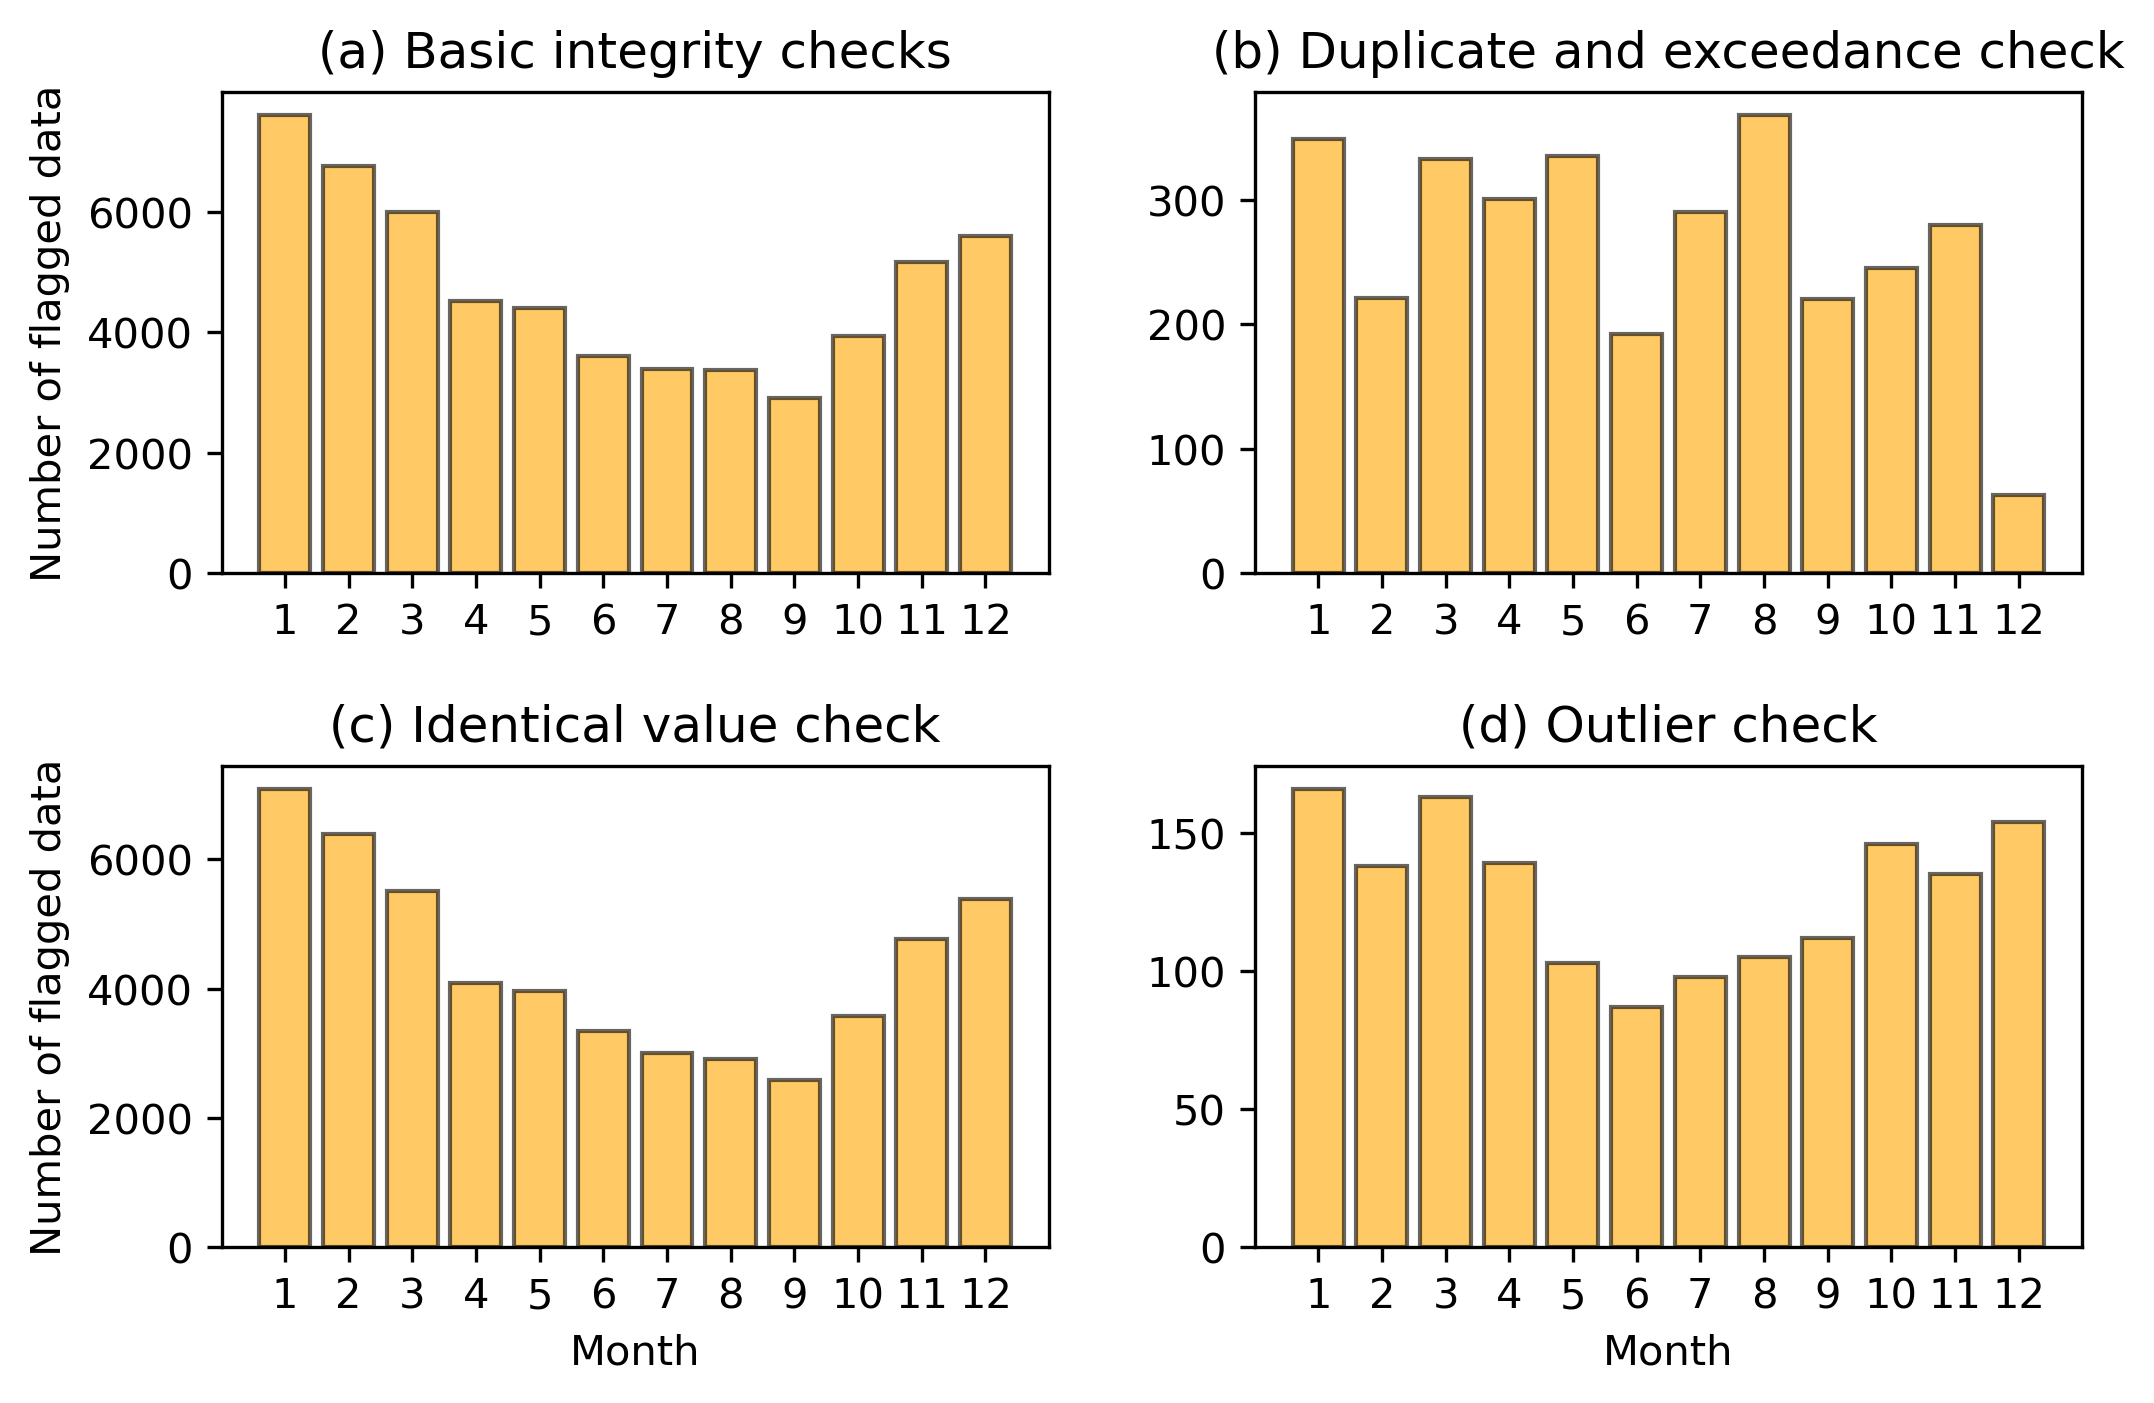

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=300)
plt.subplots_adjust(hspace=0.4, wspace=0.25)
for i, item in enumerate(["Basic integrity checks", "Duplicate and exceedance check", "Identical value check", "Outlier check"]):
    ax = axes.flatten()[i]
    # plot_data = QC_daily_tp_nonan_fail[item]
    plot_data = QC_daily_tp_nonan_fail[item].groupby("time.month").sum()

    ax.bar(plot_data.month, plot_data.data, color="orange", alpha=0.6, edgecolor='black')
    ax.set_title(f"({chr(97+i)}) {item}")
    # ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.set_xticks(plot_data.month)
    ax.set_xlabel("Month", fontsize=fontsize) if i // 2 == 1 else None
    ax.set_ylabel("Number of flagged data", fontsize=fontsize) if i % 2 == 0 else None
# ax.set_ylim(0, 10)
fig.savefig("figures/Figure 4.jpg", dpi=300, bbox_inches="tight")


# Fig.5

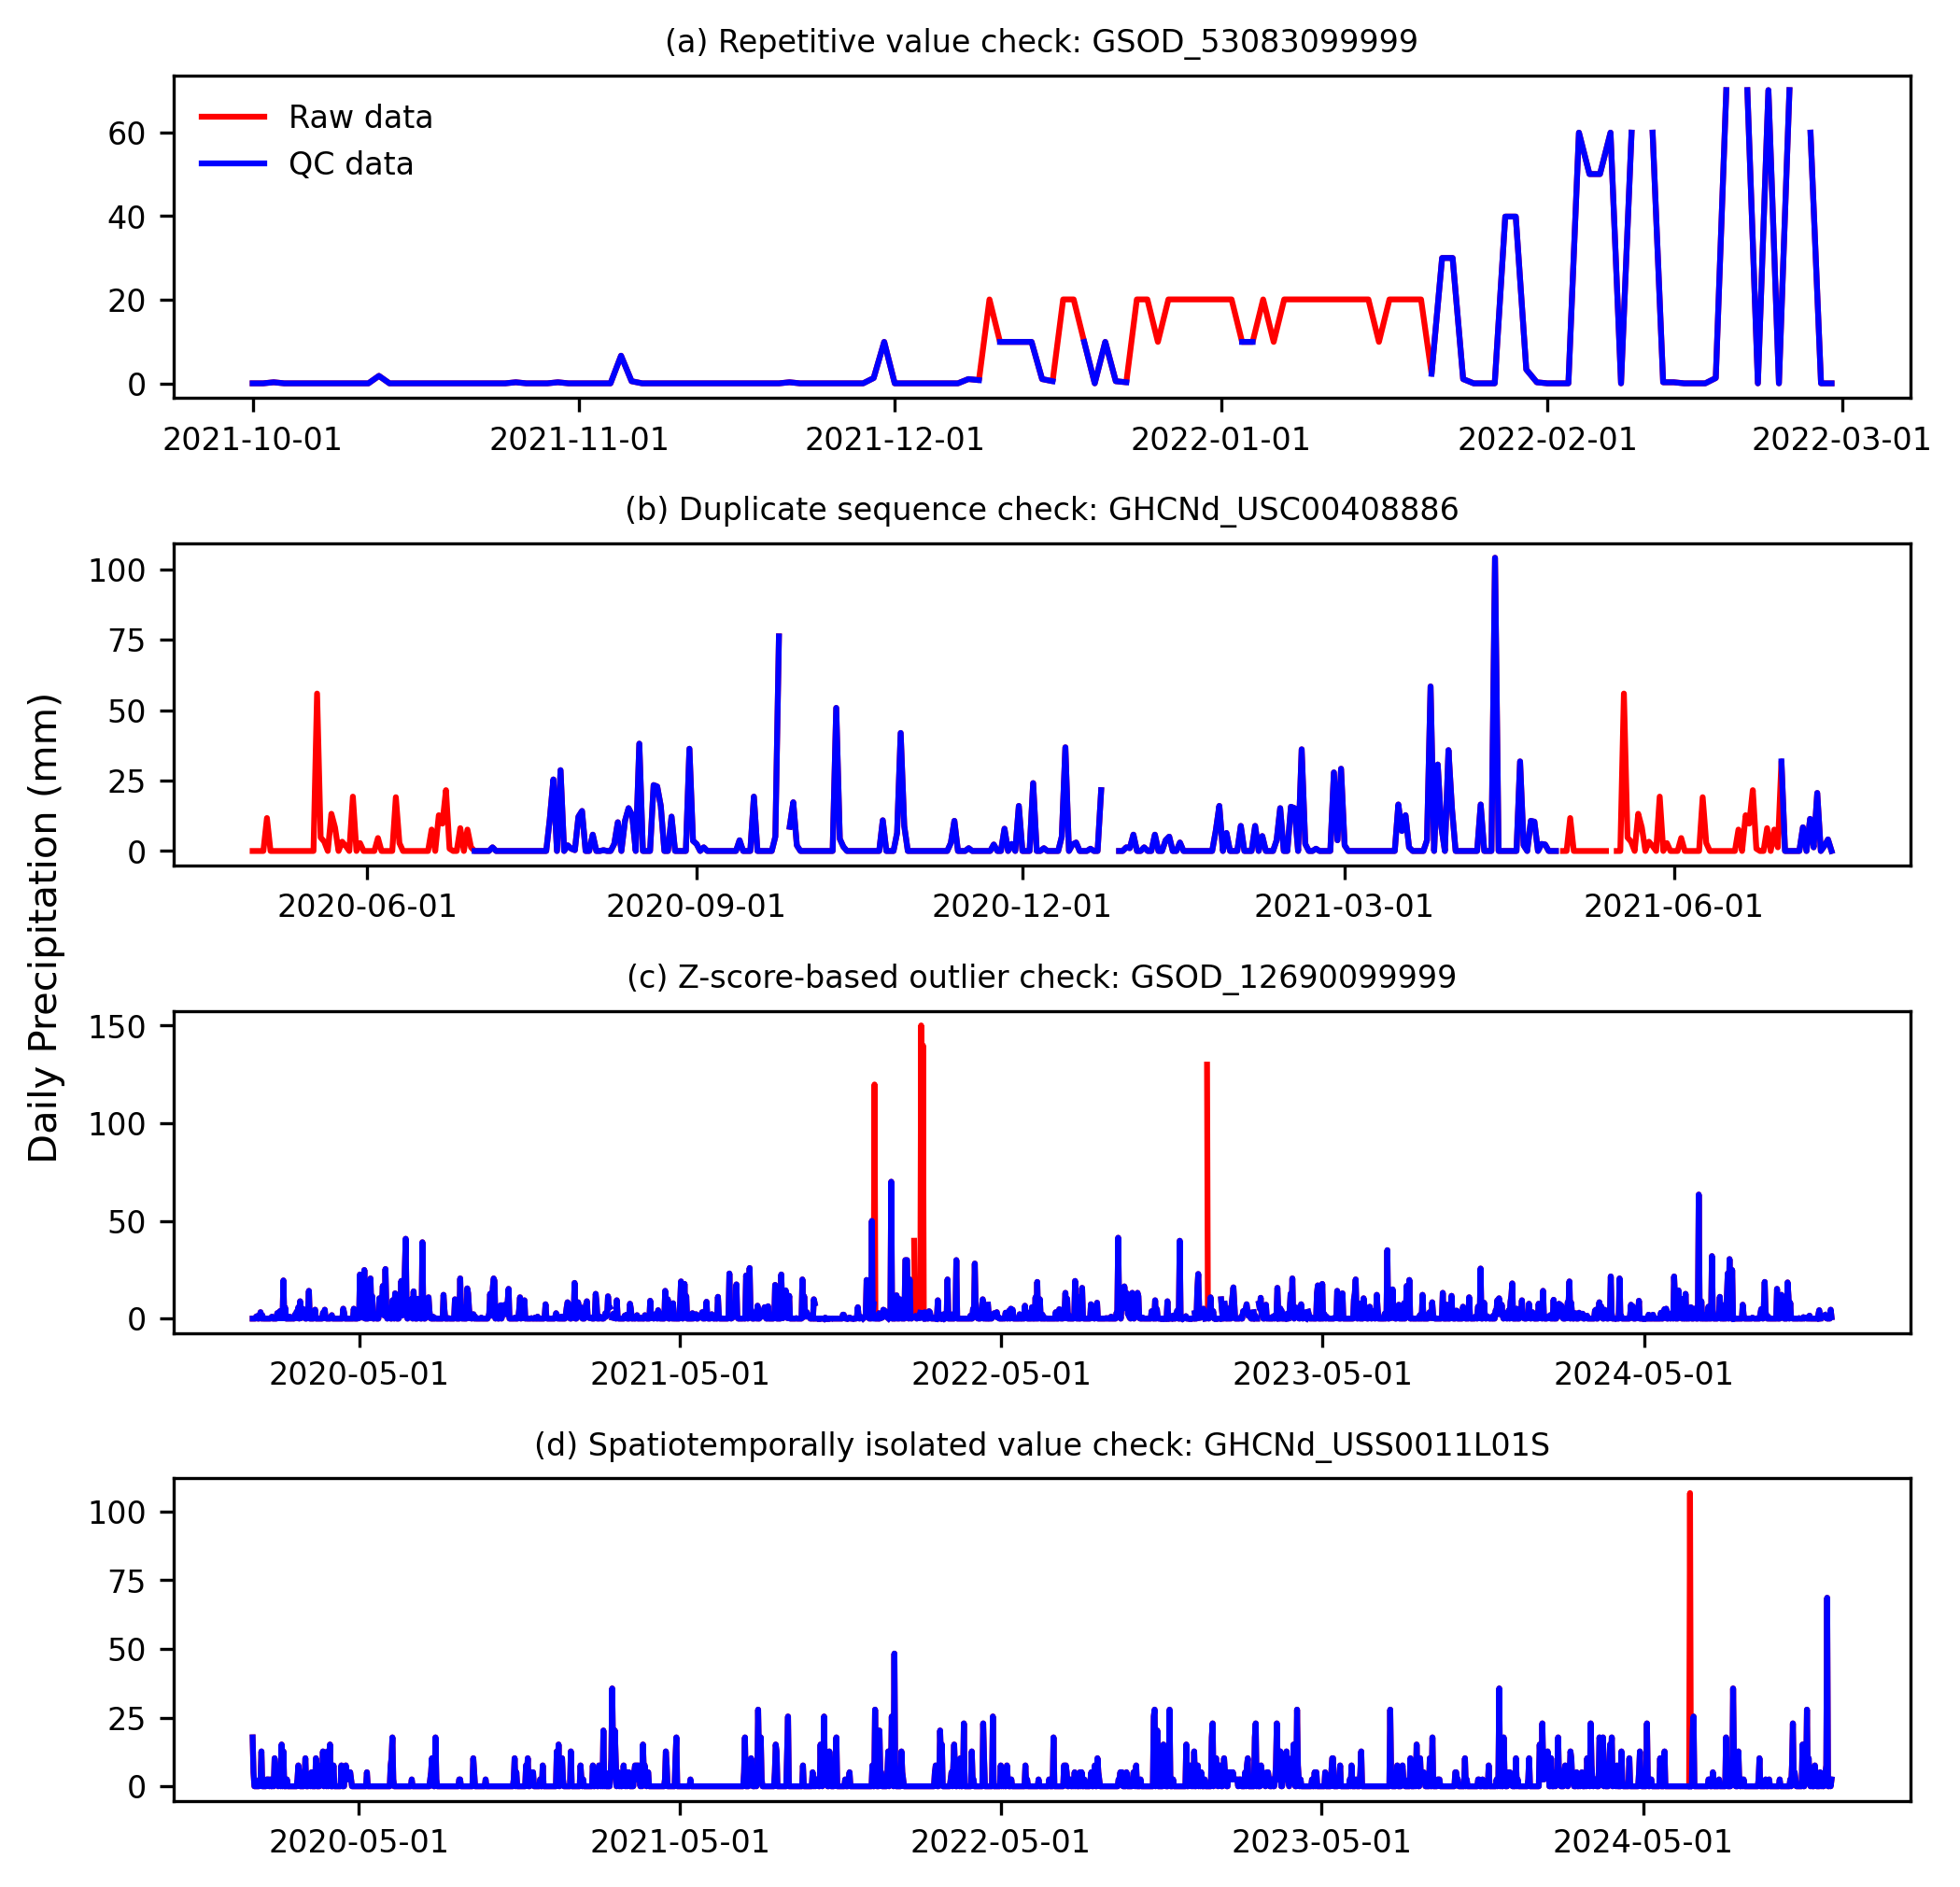

In [120]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8), dpi=300)
axes = axes.flatten()
plt.subplots_adjust(hspace=0.45)

colors = {"Raw": "red", "QC": "blue"}
fig.supylabel("Daily Precipitation (mm)", fontsize=fontsize, x=0.06)

for i, (sid, months, date_range, flag, flag_name) in enumerate([
        (53414, 1, pd.date_range(start="2021-10-01", end="2022-02-28"), 'nonzero_repetition_flags', "Repetitive value check"),
        # (26151, 3, pd.date_range(start="2022-2-15", end="2023-10-15"), 'duplicate_submonth_flags', "Duplicate sequence check"),
        (46984, 3, pd.date_range("2020-04-30", "2021-07-15"), 'duplicate_submonth_flags', "Duplicate sequence check"),
        (23550, 12, pd.date_range(start="2020-01-01", end="2024-12-01"), 'zscore_outlier_flags', "Z-score-based outlier check"),
        (22696, 12, pd.date_range(start="2020-01-01", end="2024-12-01"), 'spatiotemporally_isolated_flags', "Spatiotemporally isolated value check"),
    ]):
    ax = axes[i]
    sample = QC_daily_tp[["raw_data", "qc_data", flag]].isel(station=sid)
    station_id = sample["station"].data.item()
    ax.set_title(f"({chr(97+i)}) {flag_name}: {station_id}", fontsize=fontsize-2)
    time_range = sample["time"].sel(time=date_range)
    raw_data = sample["raw_data"].sel(time=date_range)
    qc_data = sample["raw_data"].where(sample[flag]!=0, np.nan).sel(time=date_range)
    # qc_data = sample["raw_data"].sel(time=date_range)

    # ax.scatter(time_range, raw_data, label="Raw data", color=colors["Raw"], s=1)
    # ax.scatter(time_range, qc_data, label="QC data", color=colors["QC"], s=1)
    ax.plot(time_range, raw_data, label="Raw data", color=colors["Raw"])
    ax.plot(time_range, qc_data, label="QC data", color=colors["QC"])
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=months))
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
axes[0].legend(fontsize=fontsize-2, loc="upper left", frameon=False)

fig.savefig("figures/Figure 4.jpg", dpi=300, bbox_inches="tight")


# Fig.6

In [34]:
QC_daily_tp["Spatiotemporal consistency checks"] = QC_daily_tp["nonzero_repetition_flags"] + QC_daily_tp["duplicate_submonth_flags"] + QC_daily_tp["zscore_outlier_flags"] + QC_daily_tp["spatiotemporally_isolated_flags"]
QC_daily_tp["Spatiotemporal consistency checks"] = QC_daily_tp["Spatiotemporal consistency checks"].where(QC_daily_tp["Spatiotemporal consistency checks"]>=0, -1)
QC_daily_tp["Spatiotemporal consistency checks"] = QC_daily_tp["Spatiotemporal consistency checks"].where(QC_daily_tp["Spatiotemporal consistency checks"]!=1, 0)
QC_daily_tp["Spatiotemporal consistency checks"] = QC_daily_tp["Spatiotemporal consistency checks"].where(QC_daily_tp["Spatiotemporal consistency checks"]!=2, 0)
QC_daily_tp["Spatiotemporal consistency checks"] = QC_daily_tp["Spatiotemporal consistency checks"].where(QC_daily_tp["Spatiotemporal consistency checks"]!=3, 0)
QC_daily_tp["Spatiotemporal consistency checks"] = QC_daily_tp["Spatiotemporal consistency checks"].where(QC_daily_tp["Spatiotemporal consistency checks"]!=4, 1)


In [37]:
QC_daily_tp_nonan = (QC_daily_tp[["Spatiotemporal consistency checks", "nonzero_repetition_flags", "duplicate_submonth_flags", "zscore_outlier_flags", "spatiotemporally_isolated_flags"]] != -1).sum(dim="station")
QC_daily_tp_nonan_fail = (QC_daily_tp[["Spatiotemporal consistency checks", "nonzero_repetition_flags", "duplicate_submonth_flags", "zscore_outlier_flags", "spatiotemporally_isolated_flags"]] == 0).sum(dim="station")

QC_daily_tp_nonan_fail_rate = QC_daily_tp_nonan_fail / QC_daily_tp_nonan
QC_daily_tp_nonan_fail_rate

<xarray.Dataset> Size: 105kB
Dimensions:                            (time: 2192)
Coordinates:
  * time                               (time) datetime64[ns] 18kB 2020-01-01 ...
Data variables:
    Spatiotemporal consistency checks  (time) float64 18kB 0.002681 ... 0.000775
    nonzero_repetition_flags           (time) float64 18kB 0.0003748 ... 0.0
    duplicate_submonth_flags           (time) float64 18kB 0.002364 ... 0.000775
    zscore_outlier_flags               (time) float64 18kB 2.883e-05 0.0 ... 0.0
    spatiotemporally_isolated_flags    (time) float64 18kB 0.0 0.0 ... 0.0 0.0

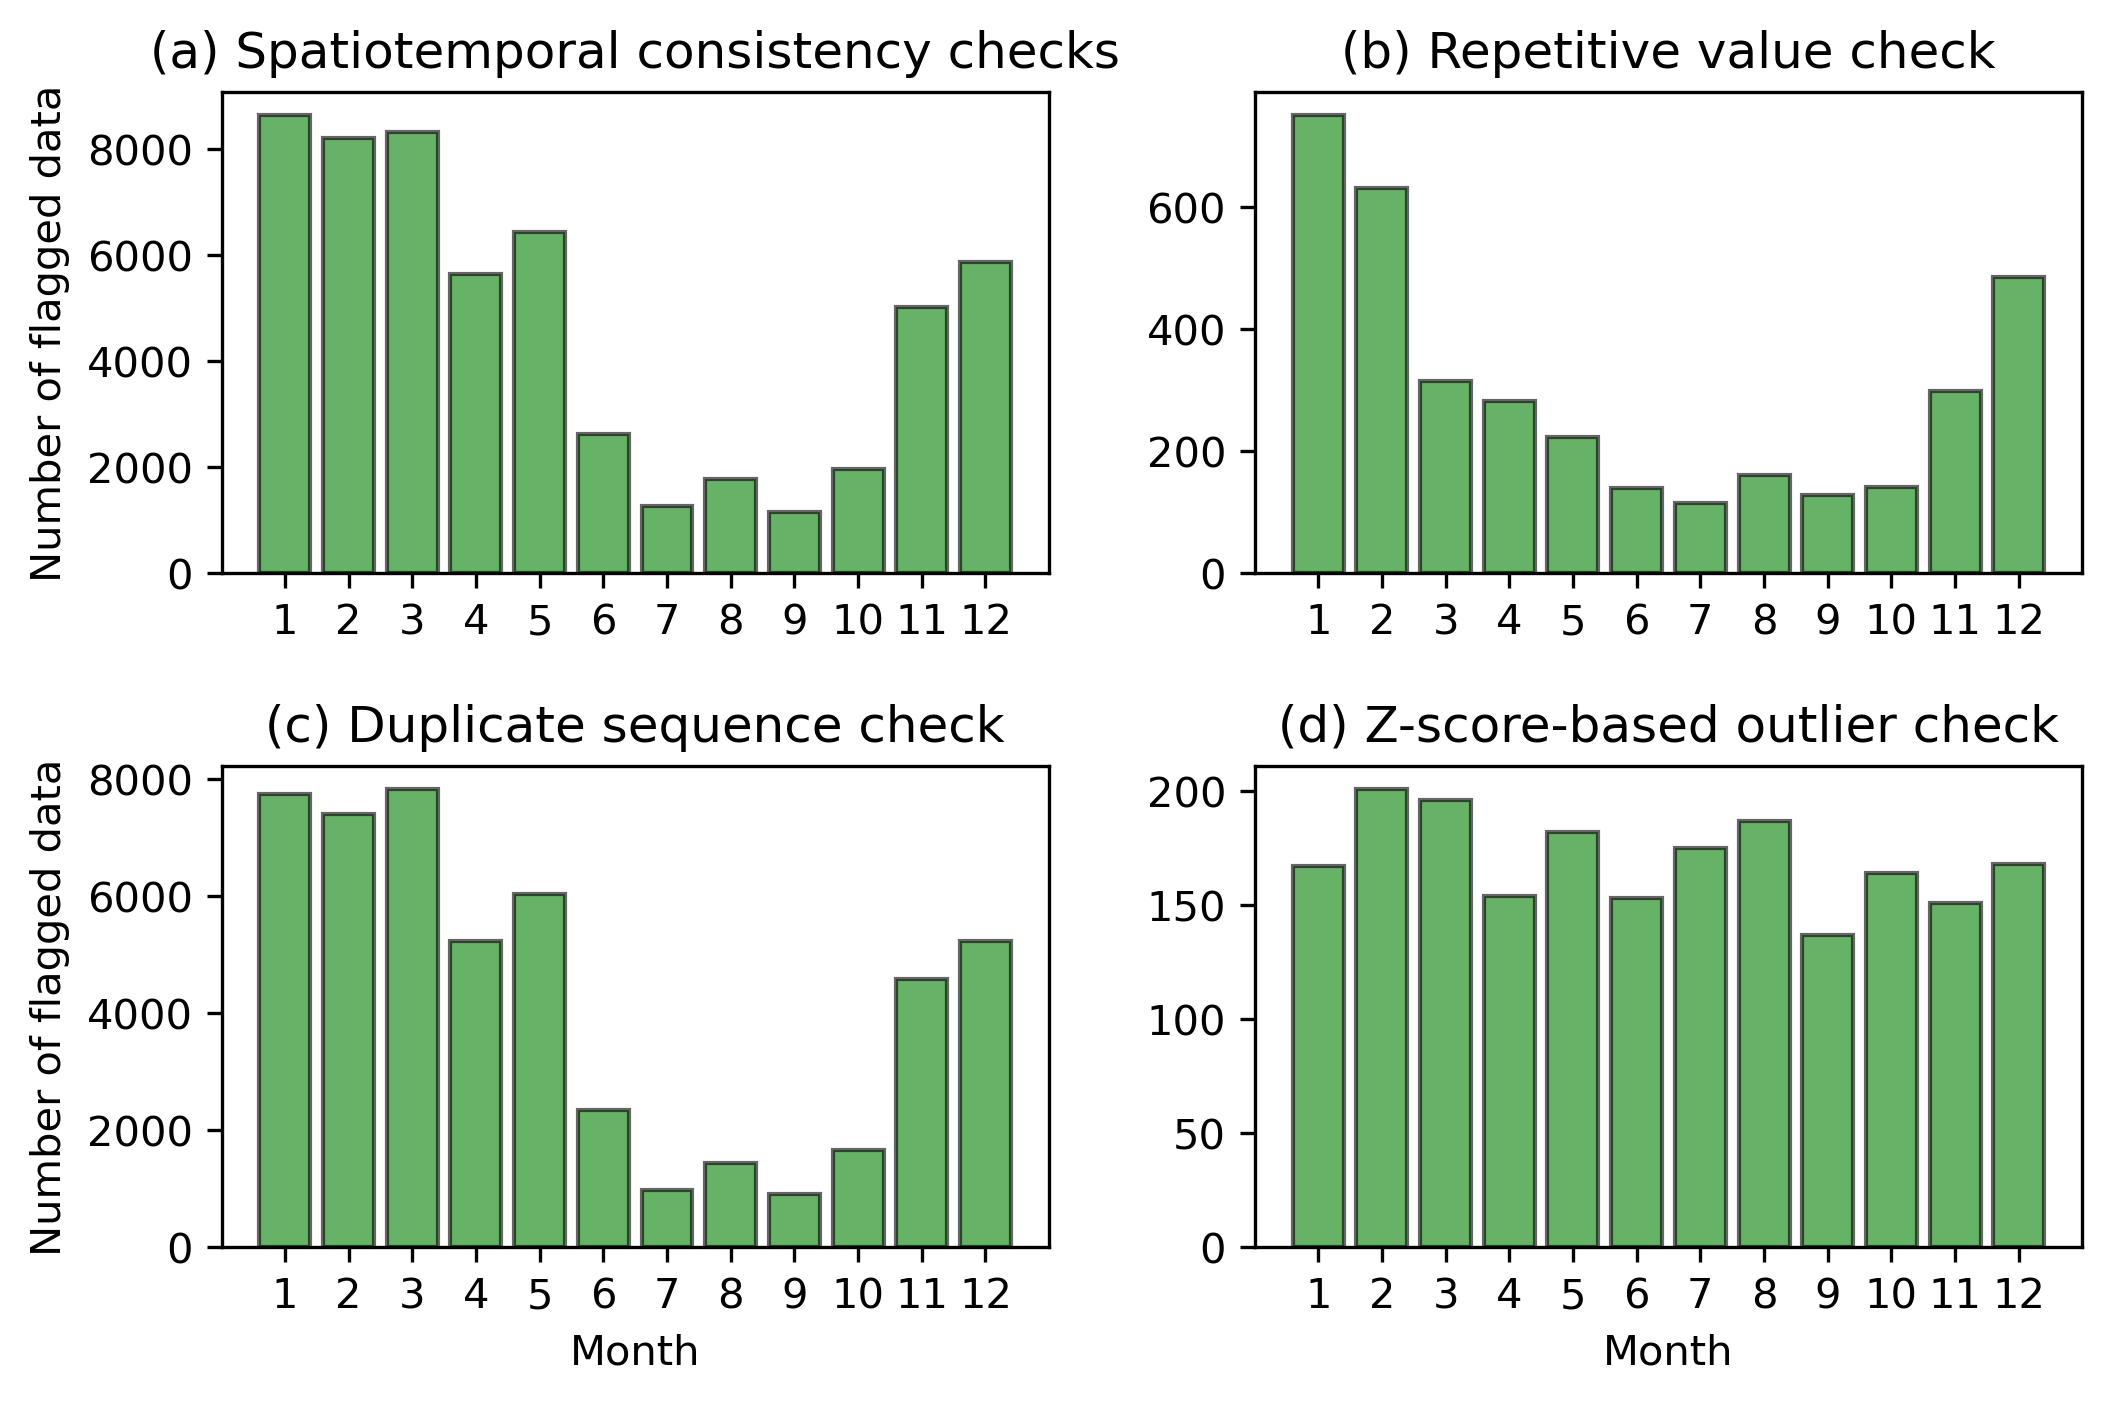

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=300)
plt.subplots_adjust(hspace=0.4, wspace=0.25)

item_dict = {"Spatiotemporal consistency checks":"Spatiotemporal consistency checks",
             'nonzero_repetition_flags': "Repetitive value check",
            'duplicate_submonth_flags': "Duplicate sequence check",
            'zscore_outlier_flags': "Z-score-based outlier check",
            'spatiotemporally_isolated_flags': "Spatiotemporally isolated value check"
            }

for i, item in enumerate(
    ["Spatiotemporal consistency checks", "nonzero_repetition_flags", "duplicate_submonth_flags", "zscore_outlier_flags"]):
    ax = axes.flatten()[i]
    # plot_data = QC_daily_tp_nonan_fail[item]
    plot_data = QC_daily_tp_nonan_fail[item].groupby("time.month").sum()

    ax.bar(plot_data.month, plot_data.data, color='green', alpha=0.6, edgecolor='black')
    ax.set_title(f"({chr(97+i)}) {item_dict[item]}")
    # ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.set_xticks(plot_data.month)
    ax.set_xlabel("Month", fontsize=fontsize) if i // 2 == 1 else None
    ax.set_ylabel("Number of flagged data", fontsize=fontsize) if i % 2 == 0 else None
    ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))
# ax.yaxis.set_major_locator(MultipleLocator(1))
fig.savefig("figures/Figure 6.jpg", dpi=300, bbox_inches="tight")


# Fig.7

In [ ]:
def plot_station_timeshift(ax, station_tp):
    bench_path_dict = {"IMERG": "IMERG_V07_Late_24h_rolling.zarr",
                       "MSWEP": "MSWEP_V280_24h_rolling.zarr",
                    #    "GPCC": "GPCC_first_guess_daily_2020_2024.nc",
                       "ERA5": "ERA5_tp_24h_rolling.zarr"}
    bench_var_dict = {"IMERG": "precipitation",
                       "MSWEP": "precipitation",
                    #    "GPCC": "p",
                       "ERA5": "tp"}
    qc_data = station_tp["qc_data"].data
    raw_data = station_tp["raw_data"].data
    ax.plot(station_tp["time"].data, raw_data, label="Raw data", color="red")
    # ax.plot(station_tp["time"].data, qc_data, label="QC data", color="blue")
    for bench_name in bench_path_dict.keys():
        bench_tp_path = BENCHMARK_DIR / bench_path_dict[bench_name]
        bench_var = bench_var_dict[bench_name]
                        
        station_tp = station_tp.load().dropna(dim="time", how="all")
        station_tp["time"] = station_tp["time"] + np.timedelta64(24, 'h')  # 调整为24小时降水量结束时间点
        station_id = station_tp.station.item()
        lat, lon = station_tp.latitude.item(), station_tp.longitude.item()
        original_station_date = station_tp.time.data
        
        if bench_name in ["GPCC", "IMERG", "MSWEP"]:
            lon = lon if lon <= 180 else lon - 360

        if bench_name == "GPCC":
            station_bench_tp = xr.open_dataset(bench_tp_path)[bench_var].sel(
                lat=lat, lon=lon, time=original_station_date, method="nearest").load()
        else:
            station_bench_tp = xr.open_zarr(bench_tp_path)[bench_var].sel(
                lat=lat, lon=lon, time=original_station_date, method="nearest").load()

        bench_data = station_bench_tp.data

        ax.plot(station_tp["time"].data, bench_data, label=f"{bench_name}")

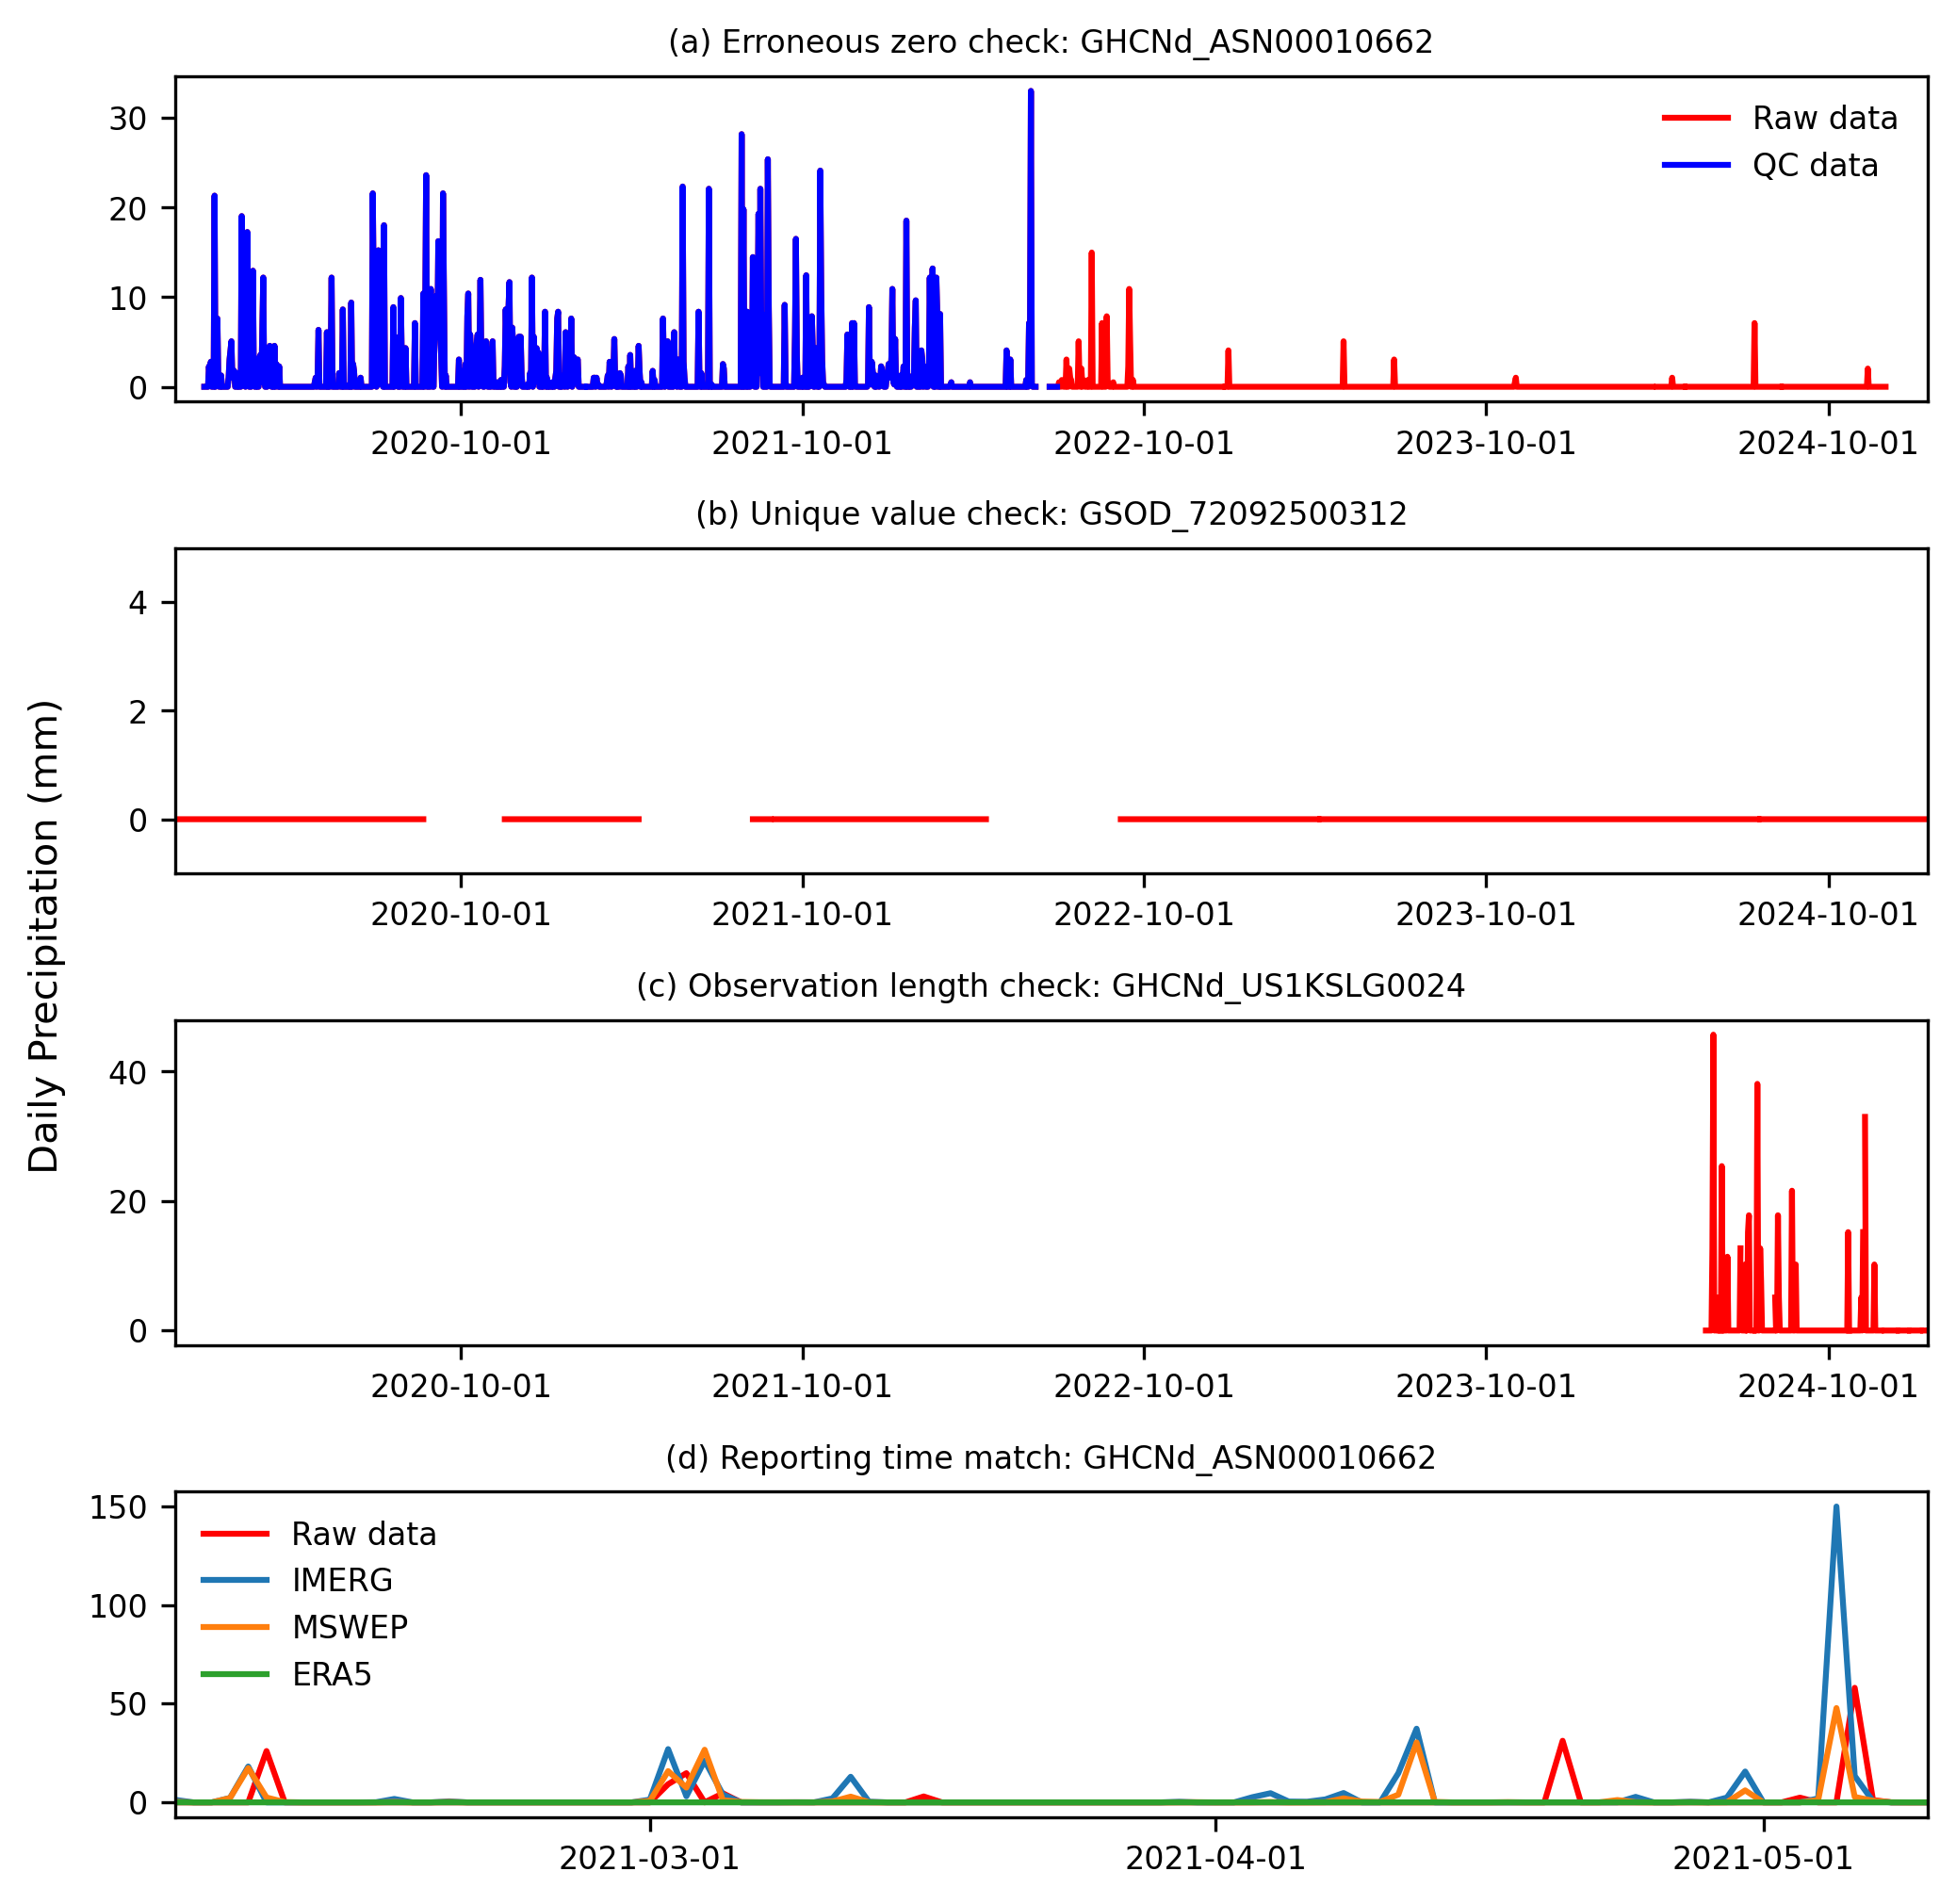

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8), dpi=300,)
axes = axes.flatten()
plt.subplots_adjust(hspace=0.45)

colors = {"Raw": "red", "QC": "blue"}
fig.supylabel("Daily Precipitation (mm)", fontsize=fontsize, x=0.06)


ax = axes[0]
ax.set_title(f"(a) Erroneous zero check: {station_id}", fontsize=fontsize-2)
flag = 'erroneous_zero_flags'
sample = QC_daily_tp[["raw_data", "qc_data",flag]].isel(station=28517)
station_id = sample["station"].data.item()
time_range = sample["time"].sel(time=date_range)
raw_data = sample["raw_data"].sel(time=date_range)
qc_data = sample["raw_data"].where(sample[flag]!=0, np.nan).sel(time=date_range)
# ax.scatter(time_range, raw_data, label="Raw data", color=colors["Raw"], s=1)
# ax.scatter(time_range, qc_data, label="QC data", color=colors["QC"], s=1)
ax.plot(time_range, raw_data, label="Raw data", color=colors["Raw"])
ax.plot(time_range, qc_data, label="QC data", color=colors["QC"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
ax.legend(fontsize=fontsize-2, loc="upper right", frameon=False)
ax.set_xlim(pd.to_datetime("2019-12-01"), pd.to_datetime("2025-01-15"))

plot_data2 = pd.read_csv("/data6t/AIWP_TP_dataset/Hamada2011_data/daily_100/GSOD_72092500312.csv", index_col=0, parse_dates=True)["PRCP"]
plot_data3 = pd.read_csv("/data6t/AIWP_TP_dataset/Hamada2011_data/daily_100/GHCNd_US1KSLG0024.csv", index_col=0, parse_dates=True)["PRCP"]

for i, (station_id, months, plot_data, flag_name) in enumerate([
        ("GSOD_72092500312", 12, plot_data2, "Unique value check"),
        ("GHCNd_US1KSLG0024", 12, plot_data3, "Observation length check"),
        # (22696, 12, plot_data4, "Spatiotemporally isolated value check"),
    ]):
    i = i + 1
    ax = axes[i]
    ax.set_title(f"({chr(97+i)}) {flag_name}: {station_id}", fontsize=fontsize-2)
    ax.plot(plot_data.index, plot_data.values, label="Raw data", color=colors["Raw"])
    # ax.scatter(plot_data.index, plot_data.values, label="Raw data", color=colors["Raw"], s=1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=months))
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    # ax.set_xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2024-12-31"))
    ax.set_xlim(pd.to_datetime("2019-12-01"), pd.to_datetime("2025-01-15"))
axes[1].set_ylim(-1, 5)
# ax = axes[0]
# sample = QC_daily_tp[["raw_data", "qc_data",qc_flag]].isel(station=28517)
# station_id = sample["station"].data.item()


ax = axes[3]

# station_id = "GHCNd_US1ILKN0145"
# station_id = "GHCNd_ASN00079035"
# station_id = "ISD_91741099999"
station_id = "GHCNd_ASN00010662"

ax.set_title(f"(d) Reporting time match: {station_id}", fontsize=fontsize-2)
plot_station_timeshift(ax, QC_daily_tp[["qc_data", "raw_data"]].sel(station=station_id))

ax.set_xlim(pd.to_datetime("2021-02-03"), pd.to_datetime("2021-05-10"))
# ax.set_xlim(pd.to_datetime("2020-03-01"), pd.to_datetime("2020-07-28"))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
ax.legend(fontsize=fontsize-2, frameon=False)

fig.savefig("figures/Figure 6.jpg", dpi=300, bbox_inches="tight")
